In [ ]:
!pip install tensorflow tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf # Ensure tensorflow is imported

img_size = (224, 224)  # ShuffleNet input size
batch_size = 32

# Correct dataset path
data_dir = "/content/drive/MyDrive/BUIS dataset/archive (6)/Dataset_BUSI_with_GT"

# Load datasets using validation_split on the main directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # Assuming a split is needed
    subset="training",
    seed=123, # Use a seed for reproducibility
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # Assuming a split is needed
    subset="validation",
    seed=123, # Use the same seed
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Class names:", class_names)

# Normalize images - adding normalization here as it's a common preprocessing step
# If normalization is handled elsewhere, you can remove this block
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 1578 files belonging to 3 classes.
Using 1263 files for training.
Found 1578 files belonging to 3 classes.
Using 315 files for validation.
Class names: ['benign', 'malignant', 'normal']


In [ ]:
import tensorflow_hub as hub

# model_url = "https://tfhub.dev/tensorflow/shufflenet_v2_x1_0/feature_vector/5" # Removed as we are using MobileNetV2

# base_model = hub.KerasLayer(model_url, input_shape=img_size+(3,), trainable=False) # Removed as we are using MobileNetV2

# model = tf.keras.Sequential([ # Removed as model is defined in cell X46DrrBBRr7t
#     base_model,
#     tf.keras.layers.Dense(len(class_names), activation="softmax")
# ])

# model.compile( # Removed as model is compiled in cell X46DrrBBRr7t
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"]
# )

# model.summary() # Removed as model summary is in cell X46DrrBBRr7t

# This cell is commented out as the model definition, compilation, and summary are handled in cell X46DrrBBRr7t.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystop_cb = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)

checkpoint_cb = ModelCheckpoint("shufflenetv2_best.h5",
                                save_best_only=True,
                                monitor="val_loss",
                                mode="min",
                                verbose=1)

reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-7)

# history = model.fit( # This code is commented out as the model training is handled in a previous cell (X46DrrBBRr7t).
#     train_ds,
#     validation_data=val_ds,
#     epochs=1000000,   # effectively unlimited
#     callbacks=[earlystop_cb, checkpoint_cb, reduce_lr_cb],
#     verbose=1
# )

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# Removed import from 'official' as the module is not available
# from official.vision.image_classification.shufflenet_v2 import ShuffleNetV2

# Ensure num_classes is defined from previous cells, or define it here if needed
# num_classes = 3 # Example if not defined

base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # Freeze the base model weights

# --- Add classification head ---
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# --- Compile ---
model.compile(optimizer=Adam(learning_rate=1e-4),
              # Use sparse_categorical_crossentropy if your labels are integers
              # Use categorical_crossentropy if your labels are one-hot encoded
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# --- Callbacks ---
earlystop_cb = EarlyStopping(monitor="val_loss",
                             patience=10,           # stop if no improvement for 10 epochs
                             restore_best_weights=True)

checkpoint_cb = ModelCheckpoint("shufflenet_best.h5", # Changed filename
                                save_best_only=True,
                                monitor="val_loss")

reduce_lr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1)

# --- Train from epoch 1 ---
# Ensure train_ds and val_ds are defined from previous cells.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000000,        # huge number (effectively unlimited)
    initial_epoch=1,       # start from 1
    # batch_size=32, # batch_size is handled by dataset
    callbacks=[earlystop_cb, checkpoint_cb, reduce_lr_cb],
    verbose=1
)

# Display model summary to confirm the change
model.summary()

Epoch 2/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2737 - loss: 1.4175

40/40 ━━━━━━━━━━━━━━━━━━━━ 36s 498ms/step - accuracy: 0.2760 - loss: 1.4122 - val_accuracy: 0.5714 - val_loss: 0.9062 - learning_rate: 1.0000e-04
Epoch 3/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5599 - loss: 0.9022

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.5608 - loss: 0.9009 - val_accuracy: 0.6571 - val_loss: 0.7535 - learning_rate: 1.0000e-04
Epoch 4/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.6610 - loss: 0.7524

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.6621 - loss: 0.7516 - val_accuracy: 0.7651 - val_loss: 0.6576 - learning_rate: 1.0000e-04
Epoch 5/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7408 - loss: 0.6597

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 237ms/step - accuracy: 0.7409 - loss: 0.6593 - val_accuracy: 0.7810 - val_loss: 0.5938 - learning_rate: 1.0000e-04
Epoch 6/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.7577 - loss: 0.6058

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.7577 - loss: 0.6054 - val_accuracy: 0.7841 - val_loss: 0.5498 - learning_rate: 1.0000e-04
Epoch 7/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7660 - loss: 0.5574

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.7660 - loss: 0.5571 - val_accuracy: 0.7905 - val_loss: 0.5180 - learning_rate: 1.0000e-04
Epoch 8/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.7873 - loss: 0.5249

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - accuracy: 0.7872 - loss: 0.5247 - val_accuracy: 0.7905 - val_loss: 0.4925 - learning_rate: 1.0000e-04
Epoch 9/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7826 - loss: 0.5087

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.7828 - loss: 0.5083 - val_accuracy: 0.7937 - val_loss: 0.4723 - learning_rate: 1.0000e-04
Epoch 10/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.7980 - loss: 0.4930

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.7981 - loss: 0.4924 - val_accuracy: 0.7937 - val_loss: 0.4553 - learning_rate: 1.0000e-04
Epoch 11/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8082 - loss: 0.4624

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.8083 - loss: 0.4621 - val_accuracy: 0.8032 - val_loss: 0.4410 - learning_rate: 1.0000e-04
Epoch 12/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8293 - loss: 0.4422

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.8293 - loss: 0.4421 - val_accuracy: 0.8032 - val_loss: 0.4288 - learning_rate: 1.0000e-04
Epoch 13/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8365 - loss: 0.4426

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.8365 - loss: 0.4422 - val_accuracy: 0.8095 - val_loss: 0.4189 - learning_rate: 1.0000e-04
Epoch 14/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8316 - loss: 0.4230

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - accuracy: 0.8319 - loss: 0.4225 - val_accuracy: 0.8127 - val_loss: 0.4089 - learning_rate: 1.0000e-04
Epoch 15/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8397 - loss: 0.4062

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 234ms/step - accuracy: 0.8400 - loss: 0.4061 - val_accuracy: 0.8190 - val_loss: 0.4010 - learning_rate: 1.0000e-04
Epoch 16/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8383 - loss: 0.4153

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - accuracy: 0.8390 - loss: 0.4142 - val_accuracy: 0.8286 - val_loss: 0.3942 - learning_rate: 1.0000e-04
Epoch 17/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8472 - loss: 0.3874

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.8473 - loss: 0.3873 - val_accuracy: 0.8349 - val_loss: 0.3874 - learning_rate: 1.0000e-04
Epoch 18/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.8549 - loss: 0.3904

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.8549 - loss: 0.3901 - val_accuracy: 0.8381 - val_loss: 0.3822 - learning_rate: 1.0000e-04
Epoch 19/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8455 - loss: 0.3918

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.8462 - loss: 0.3907 - val_accuracy: 0.8349 - val_loss: 0.3766 - learning_rate: 1.0000e-04
Epoch 20/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8591 - loss: 0.3848

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step - accuracy: 0.8594 - loss: 0.3837 - val_accuracy: 0.8381 - val_loss: 0.3721 - learning_rate: 1.0000e-04
Epoch 21/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8698 - loss: 0.3651

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.8698 - loss: 0.3649 - val_accuracy: 0.8381 - val_loss: 0.3678 - learning_rate: 1.0000e-04
Epoch 22/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8708 - loss: 0.3658

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.8708 - loss: 0.3655 - val_accuracy: 0.8413 - val_loss: 0.3636 - learning_rate: 1.0000e-04
Epoch 23/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8746 - loss: 0.3486

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 229ms/step - accuracy: 0.8747 - loss: 0.3483 - val_accuracy: 0.8381 - val_loss: 0.3598 - learning_rate: 1.0000e-04
Epoch 24/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8815 - loss: 0.3425

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.8813 - loss: 0.3424 - val_accuracy: 0.8476 - val_loss: 0.3568 - learning_rate: 1.0000e-04
Epoch 25/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.8764 - loss: 0.3419

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.8764 - loss: 0.3417 - val_accuracy: 0.8508 - val_loss: 0.3540 - learning_rate: 1.0000e-04
Epoch 26/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8904 - loss: 0.3297

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.8900 - loss: 0.3297 - val_accuracy: 0.8508 - val_loss: 0.3513 - learning_rate: 1.0000e-04
Epoch 27/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.8784 - loss: 0.3508

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.8785 - loss: 0.3502 - val_accuracy: 0.8476 - val_loss: 0.3487 - learning_rate: 1.0000e-04
Epoch 28/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8876 - loss: 0.3277

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.8875 - loss: 0.3275 - val_accuracy: 0.8476 - val_loss: 0.3461 - learning_rate: 1.0000e-04
Epoch 29/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8817 - loss: 0.3300

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.8818 - loss: 0.3297 - val_accuracy: 0.8476 - val_loss: 0.3446 - learning_rate: 1.0000e-04
Epoch 30/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8855 - loss: 0.3297

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.8856 - loss: 0.3293 - val_accuracy: 0.8444 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 31/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8892 - loss: 0.3235

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 216ms/step - accuracy: 0.8892 - loss: 0.3227 - val_accuracy: 0.8476 - val_loss: 0.3407 - learning_rate: 1.0000e-04
Epoch 32/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8927 - loss: 0.3193

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.8927 - loss: 0.3189 - val_accuracy: 0.8476 - val_loss: 0.3382 - learning_rate: 1.0000e-04
Epoch 33/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8985 - loss: 0.3104

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.8984 - loss: 0.3102 - val_accuracy: 0.8476 - val_loss: 0.3356 - learning_rate: 1.0000e-04
Epoch 34/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.8861 - loss: 0.3036

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.8863 - loss: 0.3034 - val_accuracy: 0.8508 - val_loss: 0.3345 - learning_rate: 1.0000e-04
Epoch 35/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.8950 - loss: 0.2969

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 0.8949 - loss: 0.2968 - val_accuracy: 0.8508 - val_loss: 0.3327 - learning_rate: 1.0000e-04
Epoch 36/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8938 - loss: 0.3070

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.8938 - loss: 0.3066 - val_accuracy: 0.8508 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 37/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8879 - loss: 0.3048

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.8880 - loss: 0.3043 - val_accuracy: 0.8508 - val_loss: 0.3301 - learning_rate: 1.0000e-04
Epoch 38/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9021 - loss: 0.2797

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.9020 - loss: 0.2798 - val_accuracy: 0.8508 - val_loss: 0.3285 - learning_rate: 1.0000e-04
Epoch 39/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9024 - loss: 0.2805

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9022 - loss: 0.2805 - val_accuracy: 0.8540 - val_loss: 0.3264 - learning_rate: 1.0000e-04
Epoch 40/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8982 - loss: 0.2858

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.8982 - loss: 0.2856 - val_accuracy: 0.8540 - val_loss: 0.3253 - learning_rate: 1.0000e-04
Epoch 41/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8990 - loss: 0.2730

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - accuracy: 0.8990 - loss: 0.2731 - val_accuracy: 0.8571 - val_loss: 0.3244 - learning_rate: 1.0000e-04
Epoch 42/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8949 - loss: 0.2798

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.8950 - loss: 0.2796 - val_accuracy: 0.8540 - val_loss: 0.3234 - learning_rate: 1.0000e-04
Epoch 43/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9028 - loss: 0.2726

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.9026 - loss: 0.2726 - val_accuracy: 0.8571 - val_loss: 0.3210 - learning_rate: 1.0000e-04
Epoch 44/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9081 - loss: 0.2675

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 227ms/step - accuracy: 0.9079 - loss: 0.2675 - val_accuracy: 0.8571 - val_loss: 0.3200 - learning_rate: 1.0000e-04
Epoch 45/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8929 - loss: 0.2833

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 235ms/step - accuracy: 0.8932 - loss: 0.2824 - val_accuracy: 0.8571 - val_loss: 0.3187 - learning_rate: 1.0000e-04
Epoch 46/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9017 - loss: 0.2761

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.9017 - loss: 0.2758 - val_accuracy: 0.8540 - val_loss: 0.3183 - learning_rate: 1.0000e-04
Epoch 47/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9122 - loss: 0.2574

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9121 - loss: 0.2574 - val_accuracy: 0.8603 - val_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 48/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8999 - loss: 0.2651

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - accuracy: 0.9000 - loss: 0.2649 - val_accuracy: 0.8540 - val_loss: 0.3163 - learning_rate: 1.0000e-04
Epoch 49/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9025 - loss: 0.2639

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9025 - loss: 0.2637 - val_accuracy: 0.8571 - val_loss: 0.3149 - learning_rate: 1.0000e-04
Epoch 50/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9083 - loss: 0.2576

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.9084 - loss: 0.2575 - val_accuracy: 0.8603 - val_loss: 0.3146 - learning_rate: 1.0000e-04
Epoch 51/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9063 - loss: 0.2560

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.9063 - loss: 0.2559 - val_accuracy: 0.8603 - val_loss: 0.3128 - learning_rate: 1.0000e-04
Epoch 52/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9119 - loss: 0.2458

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.9119 - loss: 0.2459 - val_accuracy: 0.8635 - val_loss: 0.3120 - learning_rate: 1.0000e-04
Epoch 53/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9105 - loss: 0.2489

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9104 - loss: 0.2489 - val_accuracy: 0.8635 - val_loss: 0.3114 - learning_rate: 1.0000e-04
Epoch 54/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9085 - loss: 0.2526

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9086 - loss: 0.2524 - val_accuracy: 0.8635 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 55/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9051 - loss: 0.2492

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.9052 - loss: 0.2490 - val_accuracy: 0.8698 - val_loss: 0.3095 - learning_rate: 1.0000e-04
Epoch 56/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 224ms/step - accuracy: 0.9098 - loss: 0.2519 - val_accuracy: 0.8698 - val_loss: 0.3100 - learning_rate: 1.0000e-04
Epoch 57/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9117 - loss: 0.2451

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9117 - loss: 0.2449 - val_accuracy: 0.8730 - val_loss: 0.3080 - learning_rate: 1.0000e-04
Epoch 58/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9148 - loss: 0.2461

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - accuracy: 0.9149 - loss: 0.2459 - val_accuracy: 0.8730 - val_loss: 0.3079 - learning_rate: 1.0000e-04
Epoch 59/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9081 - loss: 0.2427

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.9083 - loss: 0.2425 - val_accuracy: 0.8762 - val_loss: 0.3070 - learning_rate: 1.0000e-04
Epoch 60/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.9122 - loss: 0.2428 - val_accuracy: 0.8667 - val_loss: 0.3071 - learning_rate: 1.0000e-04
Epoch 61/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9126 - loss: 0.2336

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.9127 - loss: 0.2335 - val_accuracy: 0.8762 - val_loss: 0.3050 - learning_rate: 1.0000e-04
Epoch 62/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.9149 - loss: 0.2327

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9150 - loss: 0.2326 - val_accuracy: 0.8825 - val_loss: 0.3042 - learning_rate: 1.0000e-04
Epoch 63/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9170 - loss: 0.2316 - val_accuracy: 0.8762 - val_loss: 0.3045 - learning_rate: 1.0000e-04
Epoch 64/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9196 - loss: 0.2251

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9196 - loss: 0.2251 - val_accuracy: 0.8762 - val_loss: 0.3035 - learning_rate: 1.0000e-04
Epoch 65/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9157 - loss: 0.2317

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 275ms/step - accuracy: 0.9158 - loss: 0.2315 - val_accuracy: 0.8794 - val_loss: 0.3029 - learning_rate: 1.0000e-04
Epoch 66/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9200 - loss: 0.2306

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.9201 - loss: 0.2304 - val_accuracy: 0.8730 - val_loss: 0.3025 - learning_rate: 1.0000e-04
Epoch 67/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9220 - loss: 0.2242

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.9220 - loss: 0.2241 - val_accuracy: 0.8794 - val_loss: 0.3008 - learning_rate: 1.0000e-04
Epoch 68/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9185 - loss: 0.2261 - val_accuracy: 0.8730 - val_loss: 0.3009 - learning_rate: 1.0000e-04
Epoch 69/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9205 - loss: 0.2214

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 300ms/step - accuracy: 0.9206 - loss: 0.2213 - val_accuracy: 0.8762 - val_loss: 0.3003 - learning_rate: 1.0000e-04
Epoch 70/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.9255 - loss: 0.2208 - val_accuracy: 0.8730 - val_loss: 0.3005 - learning_rate: 1.0000e-04
Epoch 71/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9289 - loss: 0.2070

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 211ms/step - accuracy: 0.9289 - loss: 0.2072 - val_accuracy: 0.8730 - val_loss: 0.2994 - learning_rate: 1.0000e-04
Epoch 72/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9257 - loss: 0.2222

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.9258 - loss: 0.2220 - val_accuracy: 0.8794 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 73/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9298 - loss: 0.2157

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 0.9298 - loss: 0.2156 - val_accuracy: 0.8794 - val_loss: 0.2979 - learning_rate: 1.0000e-04
Epoch 74/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9340 - loss: 0.2013

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9340 - loss: 0.2015 - val_accuracy: 0.8794 - val_loss: 0.2974 - learning_rate: 1.0000e-04
Epoch 75/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9306 - loss: 0.2082

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - accuracy: 0.9306 - loss: 0.2082 - val_accuracy: 0.8794 - val_loss: 0.2968 - learning_rate: 1.0000e-04
Epoch 76/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9248 - loss: 0.2165

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.9250 - loss: 0.2163 - val_accuracy: 0.8730 - val_loss: 0.2967 - learning_rate: 1.0000e-04
Epoch 77/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9405 - loss: 0.2047

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9401 - loss: 0.2047 - val_accuracy: 0.8730 - val_loss: 0.2965 - learning_rate: 1.0000e-04
Epoch 78/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9316 - loss: 0.2054

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.9317 - loss: 0.2054 - val_accuracy: 0.8762 - val_loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 79/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9309 - loss: 0.2112

40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.9310 - loss: 0.2110 - val_accuracy: 0.8794 - val_loss: 0.2946 - learning_rate: 1.0000e-04
Epoch 80/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9413 - loss: 0.2041

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9412 - loss: 0.2041 - val_accuracy: 0.8730 - val_loss: 0.2941 - learning_rate: 1.0000e-04
Epoch 81/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9344 - loss: 0.2060

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9345 - loss: 0.2059 - val_accuracy: 0.8794 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 82/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9381 - loss: 0.1960

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.9381 - loss: 0.1960 - val_accuracy: 0.8825 - val_loss: 0.2923 - learning_rate: 1.0000e-04
Epoch 83/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 200ms/step - accuracy: 0.9304 - loss: 0.2077 - val_accuracy: 0.8794 - val_loss: 0.2926 - learning_rate: 1.0000e-04
Epoch 84/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9358 - loss: 0.2016

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9359 - loss: 0.2015 - val_accuracy: 0.8794 - val_loss: 0.2922 - learning_rate: 1.0000e-04
Epoch 85/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9333 - loss: 0.1926 - val_accuracy: 0.8730 - val_loss: 0.2924 - learning_rate: 1.0000e-04
Epoch 86/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9391 - loss: 0.2045

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9392 - loss: 0.2043 - val_accuracy: 0.8794 - val_loss: 0.2916 - learning_rate: 1.0000e-04
Epoch 87/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9399 - loss: 0.1999

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.9399 - loss: 0.1997 - val_accuracy: 0.8762 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 88/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9392 - loss: 0.1941

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9392 - loss: 0.1940 - val_accuracy: 0.8794 - val_loss: 0.2906 - learning_rate: 1.0000e-04
Epoch 89/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9420 - loss: 0.1893

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 231ms/step - accuracy: 0.9420 - loss: 0.1893 - val_accuracy: 0.8857 - val_loss: 0.2900 - learning_rate: 1.0000e-04
Epoch 90/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - accuracy: 0.9338 - loss: 0.1980 - val_accuracy: 0.8730 - val_loss: 0.2903 - learning_rate: 1.0000e-04
Epoch 91/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9410 - loss: 0.1812

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9410 - loss: 0.1814 - val_accuracy: 0.8762 - val_loss: 0.2885 - learning_rate: 1.0000e-04
Epoch 92/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9480 - loss: 0.1788 - val_accuracy: 0.8762 - val_loss: 0.2892 - learning_rate: 1.0000e-04
Epoch 93/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - accuracy: 0.9500 - loss: 0.1806 - val_accuracy: 0.8762 - val_loss: 0.2888 - learning_rate: 1.0000e-04
Epoch 94/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9525 - loss: 0.1827

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - accuracy: 0.9524 - loss: 0.1827 - val_accuracy: 0.8762 - val_loss: 0.2875 - learning_rate: 1.0000e-04
Epoch 95/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9485 - loss: 0.1829

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.9485 - loss: 0.1828 - val_accuracy: 0.8794 - val_loss: 0.2870 - learning_rate: 1.0000e-04
Epoch 96/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.9460 - loss: 0.1775 - val_accuracy: 0.8794 - val_loss: 0.2873 - learning_rate: 1.0000e-04
Epoch 97/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9393 - loss: 0.1944

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.9395 - loss: 0.1941 - val_accuracy: 0.8762 - val_loss: 0.2860 - learning_rate: 1.0000e-04
Epoch 98/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9545 - loss: 0.1720 - val_accuracy: 0.8794 - val_loss: 0.2863 - learning_rate: 1.0000e-04
Epoch 99/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9541 - loss: 0.1724

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9539 - loss: 0.1725 - val_accuracy: 0.8825 - val_loss: 0.2857 - learning_rate: 1.0000e-04
Epoch 100/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9489 - loss: 0.1850

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - accuracy: 0.9490 - loss: 0.1848 - val_accuracy: 0.8762 - val_loss: 0.2856 - learning_rate: 1.0000e-04
Epoch 101/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9517 - loss: 0.1796

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - accuracy: 0.9517 - loss: 0.1795 - val_accuracy: 0.8794 - val_loss: 0.2854 - learning_rate: 1.0000e-04
Epoch 102/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.9547 - loss: 0.1741 - val_accuracy: 0.8762 - val_loss: 0.2854 - learning_rate: 1.0000e-04
Epoch 103/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9557 - loss: 0.1683

40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.9556 - loss: 0.1684 - val_accuracy: 0.8794 - val_loss: 0.2847 - learning_rate: 1.0000e-04
Epoch 104/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9563 - loss: 0.1676

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.9562 - loss: 0.1677 - val_accuracy: 0.8762 - val_loss: 0.2840 - learning_rate: 1.0000e-04
Epoch 105/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9552 - loss: 0.1715

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - accuracy: 0.9551 - loss: 0.1715 - val_accuracy: 0.8857 - val_loss: 0.2839 - learning_rate: 1.0000e-04
Epoch 106/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9517 - loss: 0.1752

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.9517 - loss: 0.1751 - val_accuracy: 0.8857 - val_loss: 0.2835 - learning_rate: 1.0000e-04
Epoch 107/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - accuracy: 0.9534 - loss: 0.1689 - val_accuracy: 0.8825 - val_loss: 0.2839 - learning_rate: 1.0000e-04
Epoch 108/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9597 - loss: 0.1602

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9595 - loss: 0.1604 - val_accuracy: 0.8825 - val_loss: 0.2825 - learning_rate: 1.0000e-04
Epoch 109/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.9530 - loss: 0.1721 - val_accuracy: 0.8825 - val_loss: 0.2828 - learning_rate: 1.0000e-04
Epoch 110/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9570 - loss: 0.1654

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.9570 - loss: 0.1654 - val_accuracy: 0.8825 - val_loss: 0.2823 - learning_rate: 1.0000e-04
Epoch 111/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9591 - loss: 0.1619

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - accuracy: 0.9590 - loss: 0.1620 - val_accuracy: 0.8857 - val_loss: 0.2814 - learning_rate: 1.0000e-04
Epoch 112/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9623 - loss: 0.1614 - val_accuracy: 0.8857 - val_loss: 0.2828 - learning_rate: 1.0000e-04
Epoch 113/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9530 - loss: 0.1653

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.9530 - loss: 0.1653 - val_accuracy: 0.8857 - val_loss: 0.2809 - learning_rate: 1.0000e-04
Epoch 114/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 259ms/step - accuracy: 0.9600 - loss: 0.1562 - val_accuracy: 0.8857 - val_loss: 0.2811 - learning_rate: 1.0000e-04
Epoch 115/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 0.9581 - loss: 0.1621 - val_accuracy: 0.8857 - val_loss: 0.2811 - learning_rate: 1.0000e-04
Epoch 116/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step - accuracy: 0.9582 - loss: 0.1545 - val_accuracy: 0.8921 - val_loss: 0.2810 - learning_rate: 1.0000e-04
Epoch 117/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9591 - loss: 0.1627 - val_accuracy: 0.8857 - val_loss: 0.2814 - learning_rate: 1.0000e-04
Epoch 118/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9646 - loss: 0.1499

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9644 - loss: 0.1501 - val_accuracy: 0.8889 - val_loss: 0.2791 - learning_rate: 1.0000e-04
Epoch 119/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - accuracy: 0.9562 - loss: 0.1546 - val_accuracy: 0.8889 - val_loss: 0.2805 - learning_rate: 1.0000e-04
Epoch 120/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9564 - loss: 0.1527 - val_accuracy: 0.8857 - val_loss: 0.2798 - learning_rate: 1.0000e-04
Epoch 121/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.9586 - loss: 0.1539 - val_accuracy: 0.8921 - val_loss: 0.2794 - learning_rate: 1.0000e-04
Epoch 122/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9611 - loss: 0.1561 - val_accuracy: 0.8857 - val_loss: 0.2795 - learning_rate: 1.0000e-04
Epoch 123/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.9602 - loss: 0.1499

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.9601 - loss: 0.1500 - val_accuracy: 0.8889 - val_loss: 0.2784 - learning_rate: 1.0000e-04
Epoch 124/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9676 - loss: 0.1532 - val_accuracy: 0.8889 - val_loss: 0.2787 - learning_rate: 1.0000e-04
Epoch 125/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.9586 - loss: 0.1587

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.9587 - loss: 0.1586 - val_accuracy: 0.8857 - val_loss: 0.2783 - learning_rate: 1.0000e-04
Epoch 126/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9619 - loss: 0.1527 - val_accuracy: 0.8889 - val_loss: 0.2792 - learning_rate: 1.0000e-04
Epoch 127/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - accuracy: 0.9568 - loss: 0.1509 - val_accuracy: 0.8857 - val_loss: 0.2788 - learning_rate: 1.0000e-04
Epoch 128/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9607 - loss: 0.1561

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9607 - loss: 0.1559 - val_accuracy: 0.8857 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 129/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9671 - loss: 0.1445 - val_accuracy: 0.8825 - val_loss: 0.2784 - learning_rate: 1.0000e-04
Epoch 130/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - accuracy: 0.9713 - loss: 0.1369 - val_accuracy: 0.8889 - val_loss: 0.2775 - learning_rate: 1.0000e-04
Epoch 131/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 263ms/step - accuracy: 0.9667 - loss: 0.1503 - val_accuracy: 0.8825 - val_loss: 0.2782 - learning_rate: 1.0000e-04
Epoch 132/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9703 - loss: 0.1405

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9702 - loss: 0.1406 - val_accuracy: 0.8857 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 133/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9633 - loss: 0.1446
Epoch 133: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - accuracy: 0.9633 - loss: 0.1446 - val_accuracy: 0.8889 - val_loss: 0.2772 - learning_rate: 1.0000e-04
Epoch 134/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9744 - loss: 0.1393

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 219ms/step - accuracy: 0.9742 - loss: 0.1394 - val_accuracy: 0.8857 - val_loss: 0.2768 - learning_rate: 5.0000e-05
Epoch 135/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.9663 - loss: 0.1450 - val_accuracy: 0.8889 - val_loss: 0.2768 - learning_rate: 5.0000e-05
Epoch 136/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9610 - loss: 0.1510

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - accuracy: 0.9611 - loss: 0.1508 - val_accuracy: 0.8889 - val_loss: 0.2762 - learning_rate: 5.0000e-05
Epoch 137/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9706 - loss: 0.1373 - val_accuracy: 0.8889 - val_loss: 0.2765 - learning_rate: 5.0000e-05
Epoch 138/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - accuracy: 0.9679 - loss: 0.1509 - val_accuracy: 0.8857 - val_loss: 0.2764 - learning_rate: 5.0000e-05
Epoch 139/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - accuracy: 0.9646 - loss: 0.1466 - val_accuracy: 0.8857 - val_loss: 0.2763 - learning_rate: 5.0000e-05
Epoch 140/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9732 - loss: 0.1363

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.9729 - loss: 0.1366 - val_accuracy: 0.8857 - val_loss: 0.2757 - learning_rate: 5.0000e-05
Epoch 141/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9694 - loss: 0.1395

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.9693 - loss: 0.1395 - val_accuracy: 0.8889 - val_loss: 0.2757 - learning_rate: 5.0000e-05
Epoch 142/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 291ms/step - accuracy: 0.9700 - loss: 0.1427 - val_accuracy: 0.8857 - val_loss: 0.2757 - learning_rate: 5.0000e-05
Epoch 143/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9726 - loss: 0.1385 - val_accuracy: 0.8889 - val_loss: 0.2758 - learning_rate: 5.0000e-05
Epoch 144/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.9722 - loss: 0.1378 - val_accuracy: 0.8857 - val_loss: 0.2757 - learning_rate: 5.0000e-05
Epoch 145/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9670 - loss: 0.1426

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.9670 - loss: 0.1425 - val_accuracy: 0.8889 - val_loss: 0.2753 - learning_rate: 5.0000e-05
Epoch 146/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.9667 - loss: 0.1420 - val_accuracy: 0.8889 - val_loss: 0.2757 - learning_rate: 5.0000e-05
Epoch 147/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9678 - loss: 0.1398

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9677 - loss: 0.1398 - val_accuracy: 0.8889 - val_loss: 0.2753 - learning_rate: 5.0000e-05
Epoch 148/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.9697 - loss: 0.1358 - val_accuracy: 0.8857 - val_loss: 0.2754 - learning_rate: 5.0000e-05
Epoch 149/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - accuracy: 0.9716 - loss: 0.1399 - val_accuracy: 0.8889 - val_loss: 0.2754 - learning_rate: 5.0000e-05
Epoch 150/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9725 - loss: 0.1314

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.9724 - loss: 0.1316 - val_accuracy: 0.8889 - val_loss: 0.2749 - learning_rate: 5.0000e-05
Epoch 151/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 258ms/step - accuracy: 0.9671 - loss: 0.1390 - val_accuracy: 0.8889 - val_loss: 0.2752 - learning_rate: 5.0000e-05
Epoch 152/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9672 - loss: 0.1370 - val_accuracy: 0.8857 - val_loss: 0.2750 - learning_rate: 5.0000e-05
Epoch 153/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9701 - loss: 0.1320

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - accuracy: 0.9700 - loss: 0.1322 - val_accuracy: 0.8857 - val_loss: 0.2747 - learning_rate: 5.0000e-05
Epoch 154/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9671 - loss: 0.1409

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9671 - loss: 0.1408 - val_accuracy: 0.8857 - val_loss: 0.2743 - learning_rate: 5.0000e-05
Epoch 155/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 0.9728 - loss: 0.1352 - val_accuracy: 0.8857 - val_loss: 0.2745 - learning_rate: 5.0000e-05
Epoch 156/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.9716 - loss: 0.1318 - val_accuracy: 0.8889 - val_loss: 0.2744 - learning_rate: 5.0000e-05
Epoch 157/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.9721 - loss: 0.1325

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9720 - loss: 0.1326 - val_accuracy: 0.8857 - val_loss: 0.2743 - learning_rate: 5.0000e-05
Epoch 158/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9666 - loss: 0.1399

40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - accuracy: 0.9667 - loss: 0.1397 - val_accuracy: 0.8825 - val_loss: 0.2739 - learning_rate: 5.0000e-05
Epoch 159/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.9712 - loss: 0.1360 - val_accuracy: 0.8857 - val_loss: 0.2742 - learning_rate: 5.0000e-05
Epoch 160/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.9793 - loss: 0.1254 - val_accuracy: 0.8889 - val_loss: 0.2742 - learning_rate: 5.0000e-05
Epoch 161/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9699 - loss: 0.1324 - val_accuracy: 0.8825 - val_loss: 0.2742 - learning_rate: 5.0000e-05
Epoch 162/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9674 - loss: 0.1337

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9674 - loss: 0.1337 - val_accuracy: 0.8825 - val_loss: 0.2737 - learning_rate: 5.0000e-05
Epoch 163/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9737 - loss: 0.1322 - val_accuracy: 0.8889 - val_loss: 0.2739 - learning_rate: 5.0000e-05
Epoch 164/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 0.9732 - loss: 0.1273 - val_accuracy: 0.8825 - val_loss: 0.2737 - learning_rate: 5.0000e-05
Epoch 165/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9708 - loss: 0.1279

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9708 - loss: 0.1280 - val_accuracy: 0.8857 - val_loss: 0.2736 - learning_rate: 5.0000e-05
Epoch 166/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9717 - loss: 0.1271 - val_accuracy: 0.8889 - val_loss: 0.2737 - learning_rate: 5.0000e-05
Epoch 167/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9695 - loss: 0.1298
Epoch 167: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9695 - loss: 0.1298 - val_accuracy: 0.8889 - val_loss: 0.2740 - learning_rate: 5.0000e-05
Epoch 168/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.9724 - loss: 0.1352 - val_accuracy: 0.8889 - val_loss: 0.2737 - learning_rate: 2.5000e-05
Epoch 169/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9725 - loss: 0.1274 - val_accuracy: 0.8889 - val_loss: 0.2736 - learning_rate: 2.5000e-05
Epoch 170/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1

40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 312ms/step - accuracy: 0.9684 - loss: 0.1300 - val_accuracy: 0.8857 - val_loss: 0.2731 - learning_rate: 2.5000e-05
Epoch 171/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9729 - loss: 0.1292 - val_accuracy: 0.8889 - val_loss: 0.2735 - learning_rate: 2.5000e-05
Epoch 172/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9683 - loss: 0.1303 - val_accuracy: 0.8857 - val_loss: 0.2734 - learning_rate: 2.5000e-05
Epoch 173/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - accuracy: 0.9736 - loss: 0.1291 - val_accuracy: 0.8857 - val_loss: 0.2731 - learning_rate: 2.5000e-05
Epoch 174/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9698 - loss: 0.1312

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9698 - loss: 0.1311 - val_accuracy: 0.8857 - val_loss: 0.2730 - learning_rate: 2.5000e-05
Epoch 175/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 208ms/step - accuracy: 0.9744 - loss: 0.1324 - val_accuracy: 0.8857 - val_loss: 0.2731 - learning_rate: 2.5000e-05
Epoch 176/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 257ms/step - accuracy: 0.9684 - loss: 0.1275 - val_accuracy: 0.8857 - val_loss: 0.2732 - learning_rate: 2.5000e-05
Epoch 177/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9721 - loss: 0.1288

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.9721 - loss: 0.1288 - val_accuracy: 0.8857 - val_loss: 0.2726 - learning_rate: 2.5000e-05
Epoch 178/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.9717 - loss: 0.1286 - val_accuracy: 0.8857 - val_loss: 0.2729 - learning_rate: 2.5000e-05
Epoch 179/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.9741 - loss: 0.1253 - val_accuracy: 0.8857 - val_loss: 0.2731 - learning_rate: 2.5000e-05
Epoch 180/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9719 - loss: 0.1272 - val_accuracy: 0.8857 - val_loss: 0.2726 - learning_rate: 2.5000e-05
Epoch 181/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9752 - loss: 0.1216

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.9751 - loss: 0.1218 - val_accuracy: 0.8857 - val_loss: 0.2725 - learning_rate: 2.5000e-05
Epoch 182/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9764 - loss: 0.1230 - val_accuracy: 0.8889 - val_loss: 0.2730 - learning_rate: 2.5000e-05
Epoch 183/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9744 - loss: 0.1226 - val_accuracy: 0.8857 - val_loss: 0.2731 - learning_rate: 2.5000e-05
Epoch 184/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9724 - loss: 0.1288 - val_accuracy: 0.8857 - val_loss: 0.2727 - learning_rate: 2.5000e-05
Epoch 185/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.9729 - loss: 0.1262 - val_accuracy: 0.8857 - val_loss: 0.2726 - learning_rate: 2.5000e-05
Epoch 186/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9768 - loss: 0.1188
Epoch 186: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 

40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - accuracy: 0.9706 - loss: 0.1241 - val_accuracy: 0.8857 - val_loss: 0.2725 - learning_rate: 1.2500e-05
Epoch 188/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.9733 - loss: 0.1230 - val_accuracy: 0.8857 - val_loss: 0.2726 - learning_rate: 1.2500e-05
Epoch 189/1000000
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9730 - loss: 0.1269

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - accuracy: 0.9729 - loss: 0.1269 - val_accuracy: 0.8857 - val_loss: 0.2724 - learning_rate: 1.2500e-05
Epoch 190/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 261ms/step - accuracy: 0.9709 - loss: 0.1269 - val_accuracy: 0.8857 - val_loss: 0.2725 - learning_rate: 1.2500e-05
Epoch 191/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.9721 - loss: 0.1303
Epoch 191: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9720 - loss: 0.1302 - val_accuracy: 0.8857 - val_loss: 0.2726 - learning_rate: 1.2500e-05
Epoch 192/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.9694 - loss: 0.1236 - val_accuracy: 0.8857 - val_loss: 0.2726 - learning_rate: 6.2500e-06
Epoch 193/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.9742 - loss: 0.1227 - val_accuracy: 0.8857 - val_loss: 0.2725 - learning_rate: 6.2500e-06
Epoch 194/1000000
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 2

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,269,515 (8.66 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 7,688 (30.04 KB)

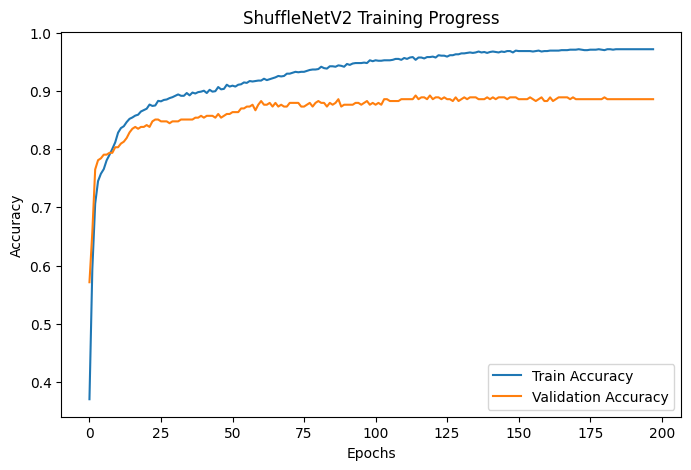

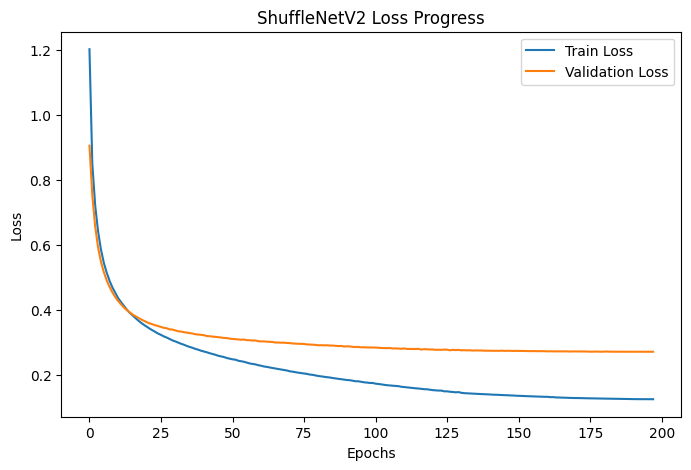

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ShuffleNetV2 Training Progress')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('ShuffleNetV2 Loss Progress')
plt.legend()
plt.show()


Classification Report:

              precision    recall  f1-score   support

      benign       0.89      0.93      0.91       180
   malignant       0.84      0.82      0.83        80
      normal       0.94      0.84      0.88        55

    accuracy                           0.89       315
   macro avg       0.89      0.86      0.87       315
weighted avg       0.89      0.89      0.89       315



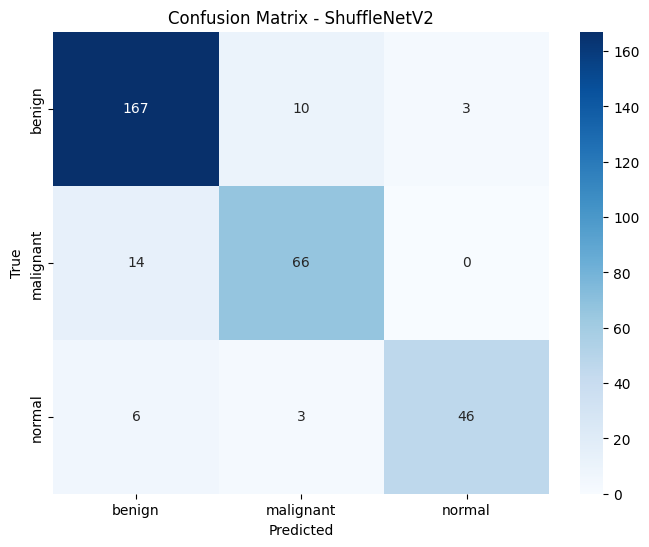

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 🔹 Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 🔹 Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 🔹 Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# 🔹 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - ShuffleNetV2")
plt.show()


In [ ]:
# Save MobileNetV3 model in .h5 format
mobilenetv3_model.save("/content/drive/MyDrive/mobilenetv3_model.h5")
print("MobileNetV3 model saved successfully!")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.8806 - loss: 0.2768
✅ Validation Accuracy: 0.8857142925262451


In [ ]:
# Save the trained model in .h5 format
model.save("my_classification_model.h5")


In [ ]:
model.save("/content/drive/MyDrive/my_classification_model.h5")
